In [1]:
# Data handling libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Natural Language Processing (NLP) libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

# Machine Learning libraries
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Utility libraries
import warnings
import pickle
import time

In [2]:
df = pd.read_csv('phishing_dataset.csv')
df

,URL,Label
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


# Feature Engineering

In [3]:
# Tokenizing URLs using RegexpTokenizer
tokenizer = RegexpTokenizer(r'[A-Za-z]+')  # Tokenize alphabetic characters
df['text_tokenized'] = df["URL"].map(lambda t: tokenizer.tokenize(t))

# Use SnowballStemmer to stem the words
stemmer = SnowballStemmer("english")
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

# Joining the words back into a single string per URL
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

df

,URL,Label,text_tokenized,text_stemmed,text_sent
0,http://www.crestonwood.com/router.php,0,"[http, www, crestonwood, com, router, php]","[http, www, crestonwood, com, router, php]",http www crestonwood com router php
1,http://shadetreetechnology.com/V4/validation/a...,1,"[http, shadetreetechnology, com, V, validation...","[http, shadetreetechnolog, com, v, valid, a, a...",http shadetreetechnolog com v valid a aedc ae ...
2,https://support-appleld.com.secureupdate.duila...,1,"[https, support, appleld, com, secureupdate, d...","[https, support, appleld, com, secureupd, duil...",https support appleld com secureupd duilawyery...
3,http://rgipt.ac.in,0,"[http, rgipt, ac, in]","[http, rgipt, ac, in]",http rgipt ac in
4,http://www.iracing.com/tracks/gateway-motorspo...,0,"[http, www, iracing, com, tracks, gateway, mot...","[http, www, irac, com, track, gateway, motorsp...",http www irac com track gateway motorsport park
...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,"[http, www, fontspace, com, category, blacklet...","[http, www, fontspac, com, categori, blacklett]",http www fontspac com categori blacklett
11426,http://www.budgetbots.com/server.php/Server%20...,1,"[http, www, budgetbots, com, server, php, Serv...","[http, www, budgetbot, com, server, php, serve...",http www budgetbot com server php server updat...
11427,https://www.facebook.com/Interactive-Televisio...,0,"[https, www, facebook, com, Interactive, Telev...","[https, www, facebook, com, interact, televis,...",https www facebook com interact televis pvt lt...
11428,http://www.mypublicdomainpictures.com/,0,"[http, www, mypublicdomainpictures, com]","[http, www, mypublicdomainpictur, com]",http www mypublicdomainpictur com


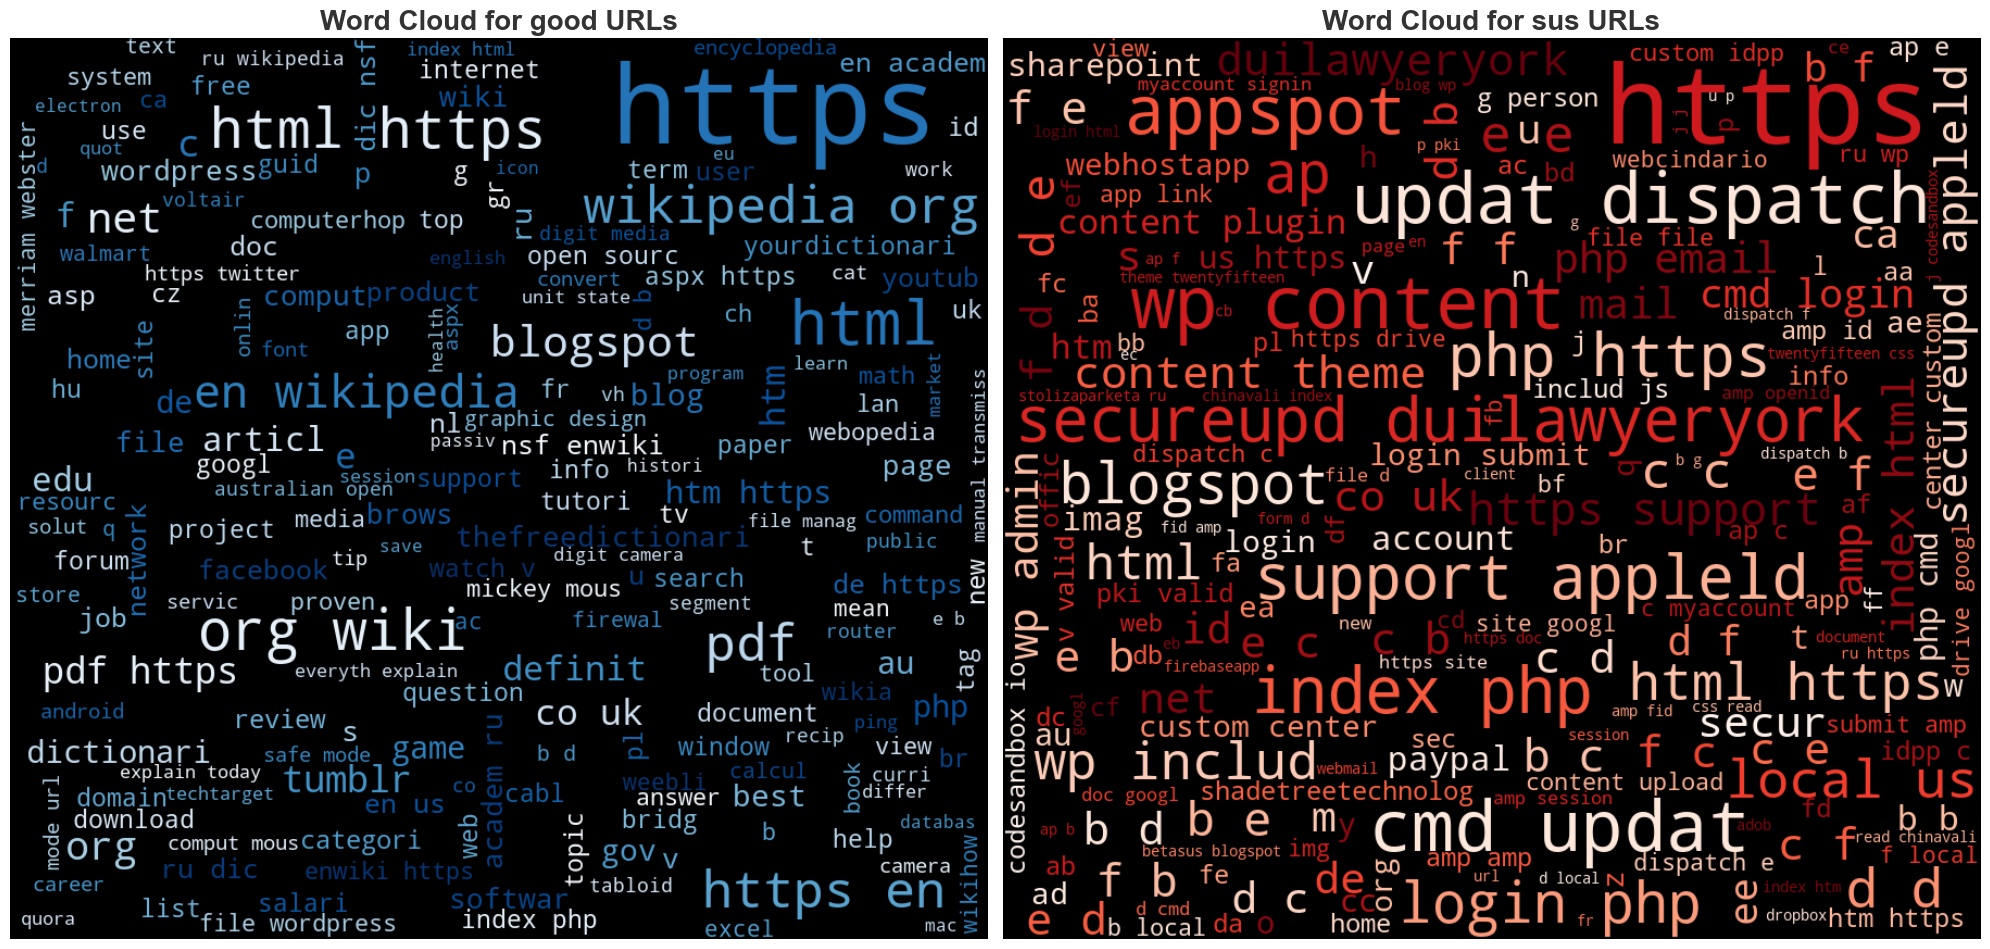

In [17]:
# Separate the text based on the labels
text_label_1 = ' '.join(df['text_sent'][df["Label"] == 1])  
text_label_0 = ' '.join(df['text_sent'][df["Label"] == 0])  

# Choose a style for the plot
sns.set_style('darkgrid')  
sns.set_palette("crest") 

# Create word clouds for both labels

# Word cloud for label 0
wordcloud_0 = WordCloud(
    background_color="black",
    width=900,
    height=830,
    max_words=200,
    colormap="Blues",
    contour_color='white',
    contour_width=2,
    min_font_size=12,
    max_font_size=100,
    prefer_horizontal=0.9,
    random_state=42
).generate(text_label_0)

# Word cloud for label 1
wordcloud_1 = WordCloud(
    background_color="black",
    width=900,
    height=830,
    max_words=200,
    colormap="Reds",
    contour_color='white',
    contour_width=2,
    min_font_size=12,
    max_font_size=100,
    prefer_horizontal=0.9,
    random_state=42
).generate(text_label_1)

# Create a subplot for both word clouds
plt.figure(figsize=(20, 18))

# Plot word clouds
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for good URLs', fontsize=20, fontweight='bold', color='#333333')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for sus URLs', fontsize=20, fontweight='bold', color='#333333')

# Adjust layout
plt.tight_layout()
plt.show()

# Machine learning

In [5]:
# Setup random seed
random_seed=42

# Vectorizing the text data using CountVectorizer
cv = CountVectorizer()
features = cv.fit_transform(df["text_sent"])

# Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# Train the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=random_seed)

# Use cross_validate to compute multiple metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(lr, features, df["Label"], cv=cv_strategy, scoring=scoring_metrics)

# Print the results
print("=" * 50)
print("5-Fold Cross-Validation Results:")
print("-" * 50)

# Accuracy, Precision, Recall, F1 Score
metrics = {
    "Accuracy": cv_results['test_accuracy'],
    "Precision": cv_results['test_precision'],
    "Recall": cv_results['test_recall'],
    "F1 Score": cv_results['test_f1']
}

for metric, values in metrics.items():
    mean_value = values.mean()
    std_value = values.std()
    print(f"{metric:12}: {mean_value:.4f} ± {std_value:.4f}")

print("=" * 50)

5-Fold Cross-Validation Results:
--------------------------------------------------
Accuracy    : 0.9122 ± 0.0035
Precision   : 0.9095 ± 0.0060
Recall      : 0.9157 ± 0.0026
F1 Score    : 0.9126 ± 0.0033


In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

# Create a pipeline with CountVectorizer and LogisticRegression
pipeline_ls = make_pipeline(
    CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'),
    LogisticRegression(max_iter=1000, random_state=random_seed)
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["URL"], df["Label"], test_size=0.2, random_state=random_seed)

# Train the pipeline
pipeline_ls.fit(X_train, y_train)

,steps,"[('countvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<bound method...NE|re.DOTALL)>


In [7]:
# Make predictions on the test data
y_pred = pipeline_ls.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1157
           1       0.92      0.90      0.91      1129

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



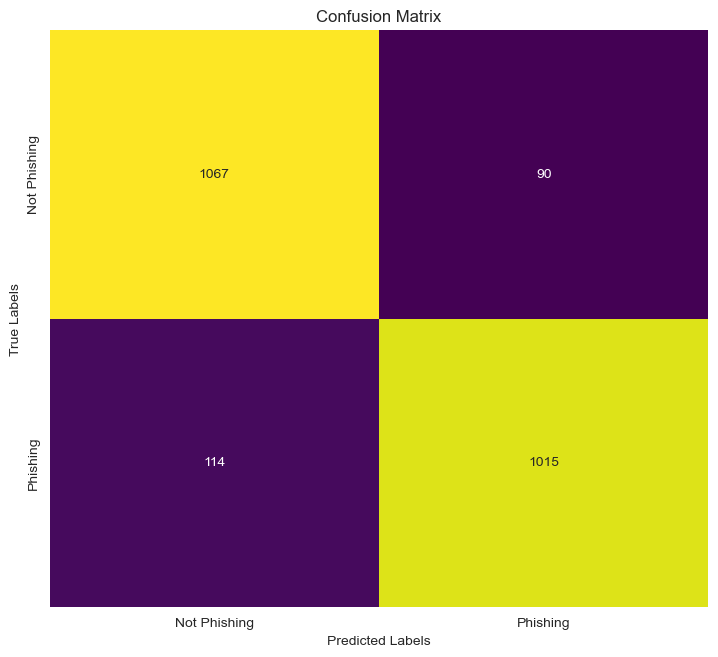

In [19]:
# Manually define the class names for binary classification
class_names = ['Not Phishing', 'Phishing']  

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8.5, 7.5))  # Set figure size

# Plot the confusion matrix with annotations and class names
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis', cbar=False)

# Add labels and title to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

In [9]:
# Save the trained model
pickle.dump(pipeline_ls, open('phishing.pkl', 'wb'))

In [10]:
# Load the saved model
loaded_model = pickle.load(open('phishing.pkl', 'rb'))

# Evaluate the model on the test set
result = loaded_model.score(X_test, y_test)  
print(f"Model accuracy on test data: {result}")

Model accuracy on test data: 0.910761154855643


In [14]:
# URLs to predict
predict_bad = [
    'yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',
    'fazan-pacir.rs/temp/libraries/ipad',
    'http://www.budgetbots.com/server.php/Server%20',
    'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt'
]

predict_good = [
    'youtube.com/',
    'youtube.com/watch?v=qI0TQJI3vdU',
    'https://www.reddit.com/r/math/',
    'https://github.com/'
]

# Load the saved model
loaded_model = pickle.load(open('phishing.pkl', 'rb'))

# Predict the labels for the bad and good URLs
result_bad = loaded_model.predict(predict_bad)
result_good = loaded_model.predict(predict_good)

# Output the predictions in a readable format
print("=" * 50)
print("Predictions for URLs:\n")
print("-" * 50)

# Bad URLs predictions
print("Bad URLs Predictions:")
for url, prediction in zip(predict_bad, result_bad):
    print(f"URL: {url} | Prediction: {'Phishing' if prediction else 'Safe'}")

print("\n" + "-" * 50)

# Good URLs predictions
print("Good URLs Predictions:")
for url, prediction in zip(predict_good, result_good):
    print(f"URL: {url} | Prediction: {'Phishing' if prediction else 'Safe'}")

print("=" * 50)

Predictions for URLs:

--------------------------------------------------
Bad URLs Predictions:
URL: yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php | Prediction: Phishing
URL: fazan-pacir.rs/temp/libraries/ipad | Prediction: Phishing
URL: http://www.budgetbots.com/server.php/Server%20 | Prediction: Phishing
URL: svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt | Prediction: Phishing

--------------------------------------------------
Good URLs Predictions:
URL: youtube.com/ | Prediction: Safe
URL: youtube.com/watch?v=qI0TQJI3vdU | Prediction: Safe
URL: https://www.reddit.com/r/math/ | Prediction: Safe
URL: https://github.com/ | Prediction: Safe
